In [1]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import networkx as nx
import matplotlib.pyplot as plt
import statistics as st
# Python Lib POWER LAW: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777 
import powerlaw

# Definition
###### In Chapter 4, Barabasi show characteristics that distingue Random Networks from Scale-Free Networks, and how many real-world networks are scale-free
###### Scale-Free networks have a degree distribution that is similar to a Power Law.<br> Power laws are probability distributions with the form:p(x) ∝ x^−α
###### In practical means, scale-free networks have many nodes with few neighbors and few nodes with many neighors (Hubs). The biggest differente between Random e Scale-Free networks are Hubs: Random must not have hubs; Scale Free must have hubs

###### In Chapter 4, Barabasi show characteristics that distingue Random Networks from Scale-Free Networks, and how many real-world networks are scale-free.
###### Scale-Free networks have a degree distribution that is similar to a Power Law. <br> Power laws are probability distributions with the form:p(x) ∝ x^−α.
######  In practical means, scale-free networks have many nodes with few neighbors and few nodes with many neighbors (Hubs). The biggest difference between Random e Scale-Free networks are Hubs: Random must not have hubs; Scale-Free must have hubs.

# Degree Exponent
"Many properties of a scale-free network depend on the value of the degree exponent γ. A close inspection of Table 4.1 indicates that: <br> γ varies from system to system, prompting us to explore how the properties of a network change with γ. <br> For most real systems the degree exponent is above 2"
###### Albeit important, the Degree Exponent is hard to measure: 
"As the properties of scale-free networks depend on the degree exponent (SECTION 4.7), we need to determine the value of γ. We face several difficulties, however, when we try to fit a power law to real data. The most important is the fact that the scaling is rarely valid for the full range of the degree distribution."
    
###### There are other ways to analyze the scale-free properties without the exponent:
"While it would be desirable to statistically validate the precise form of the degree distribution, often it is sufficient to decide if a given network has an exponentially bounded or a fat tailed degree distribution (see ADVANCED TOPICS 4.A). If the degree distribution is exponentially bounded, the random network model offers a reasonable starting point to understand its topology. If the degree distribution is fat tailed, a scale-free network offers a better approximation. We will also see in the coming chapters that the key signature of the fat tailed behavior is the magniture of 〈k2〉: If 〈k2〉 is large, systems behave like scale-free networks; if 〈k2〉 is small, being comparable to 〈k〉(〈t〉+1), systems are well approximated by random networks" <br>
OBS:〈k2〉 is the second moment of the distribution (〈k^2〉)
<br><br>
"In general if wish to obtain an accurate fit to the degree distribution, we first need to build a generative model that analytically predicts the functional form of pk. Yet, in many systems developing an accurate theory for pk may be an overkill. It is often sufficient, instead, to establish if we are dealing with an exponentially bounded or a heavy tailed degree distribution (SECTION 4.9), as the system’s properties will be primarily driven by this distinction"

# This notebook and the PowerLaw Package
###### In this notebook, we analyze the degree distribution following the measures Barabasi shown in Table 4.1. We use the PowerLaw Package (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777#pone-0085777-g001) to extract the (estimated) degree exponent and a Ratio comparison between the network degree distribution and a pure power-law and exponential distribution. The last section of this notebook presents an overview of these comparisons.

# Functions

In [2]:
def distributionComparison(G):
    degree=sorted(dict(G.degree()).values(),reverse=True)
    fit = powerlaw.Fit(degree,verbose=False)
    print('Comparasion with others distributions. The values area the Ration and pValue\n')

    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True) 
    print('power_law | exponential:          ',R,p)

    R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True) 
    print('power_law | lognormal             ',R,p)

    R, p = fit.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True) 
    print('power_law | truncated_power_law:  ',R,p)

    R, p = fit.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True) 
    print('power_law | stretched_exponential:',R,p)

    R, p = fit.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True) 
    print('power_law | lognormal_positive:   ',R,p)

def scaleFreeMeasures(G):    
    degree=sorted(dict(G.degree()).values(),reverse=True)
    
    #Fitting with powerlaw lib #We let the lib choose the xmin
    fit = powerlaw.Fit(degree,verbose=False)
    # Comparing the distribution with a power law, and a exponential # R is the Ratio and p is the p-value
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)    
    
    #General information
    info={}
    info['N']=len(G.nodes) # Number of Nodes
    info['L']=len(G.edges) # Number of Edges
    info['<k>']= round(st.mean(degree),2) #Average degree
    info['<k2>']= round(st.variance(degree) + st.mean(degree)**2,2) #The 2 moment of the degree
    info['Kmax']= max(degree) #Biggest hub
    
    kmin=fit.power_law.xmin #Nodes with degree < than kmin are discarded from the distribution in order the find the gamma
    gamma=fit.power_law.alpha # Degree Exponent (after xmin)  
    info['kMinCut'] = kmin    
    info['PowerLawRatio'] = round(R,3)
    info['pValue'] = round(p,4)
    info['Gamma'] = round(gamma,3)
    return info       
    
def scaleFreePlot(G,name=''): 
    degree=sorted(dict(G.degree()).values(),reverse=True)
    fit = powerlaw.Fit(degree,verbose=False)
    
    #Call the function to get the measures    
    info = scaleFreeMeasures(G)
    resume = str(info).replace('{','').replace('}','').replace('\'','').replace(',',' |')
    
    fig, ax = plt.subplots(2,2,figsize=(15, 15))
    fig.suptitle(name+'\n'+resume, fontsize=16)    
    ####-------------------PowerLaw Lib
    plt.sca(ax[0,0])
    ax[0,0] = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='g', linestyle='--', ax=ax[0,0])
    ax[0,0].set_title('PowerLaw Fitting ')    
    # THE OTHERS PLOTS SHOW THE PROBABILITY OF EACH UNIQUE VALUE IN THE DISTRIBUTION HAPPENS
    #Frequence of each value
    freq={}
    length = len(degree)
    for v in degree:
        if(v in freq):
            freq[v]+=1
        else:
            freq[v]=1            
    #Probability of a 'd' value happens
    pk={}        
    for f in freq:
        pk[f]=freq[f]/length 
    x=list(pk.keys())
    y=list(pk.values())    
    ####-------------------Probability Linear
    plt.sca(ax[0,1])
    ax[0,1].plot(x,y,'.')
    ax[0,1].set_title('Probability Linear')
    ax[0,1].set_xlabel('K',fontsize=18)
    ax[0,1].set_ylabel(r'$p_k$',rotation = 0,fontsize=22)
    ####-------------------Probability LogLog
    plt.sca(ax[0,1])
    ax[1,0].loglog(x,y,'o')
    ax[1,0].set_title('Probability LogLog')
    ax[1,0].set_xlabel('K',fontsize=18)
    ax[1,0].set_ylabel(r'$p_k$',rotation = 0,fontsize=22)
    ####------------------Cumulative Probability
    plt.sca(ax[1,1])
    #cumulative degree distribution
    xAxes=[]
    yAxes=[]
    cum=0
    #pk was calculated above
    for k,v in pk.items():
        cum+=v
        xAxes.append(k)
        yAxes.append(cum)
    ax[1,1].loglog(xAxes,yAxes,'o')
    ax[1,1].set_title('Cumulative')
    ax[1,1].set_xlabel('K',fontsize=18)
    ax[1,1].set_ylabel(r'$p_k$',rotation = 0,fontsize=22)
    plt.show()

# Examples
###### We run the analysis in 3 different network models. Note that the first 2 have the same number of nodes and edges

## Barabasi Albert

In [17]:
scaleFree = nx.barabasi_albert_graph(10000,3)
scaleFree.name = "barabasi_albert_graph(10000,3)"
print(nx.info(scaleFree))
degree=sorted(dict(scaleFree.degree()).values(),reverse=True)
print("10 biggest hubs degress:",degree[:10])

Name: barabasi_albert_graph(10000,3)
Type: Graph
Number of nodes: 10000
Number of edges: 29991
Average degree:   5.9982
10 biggest hubs degress: [396, 317, 201, 196, 183, 177, 147, 130, 129, 116]


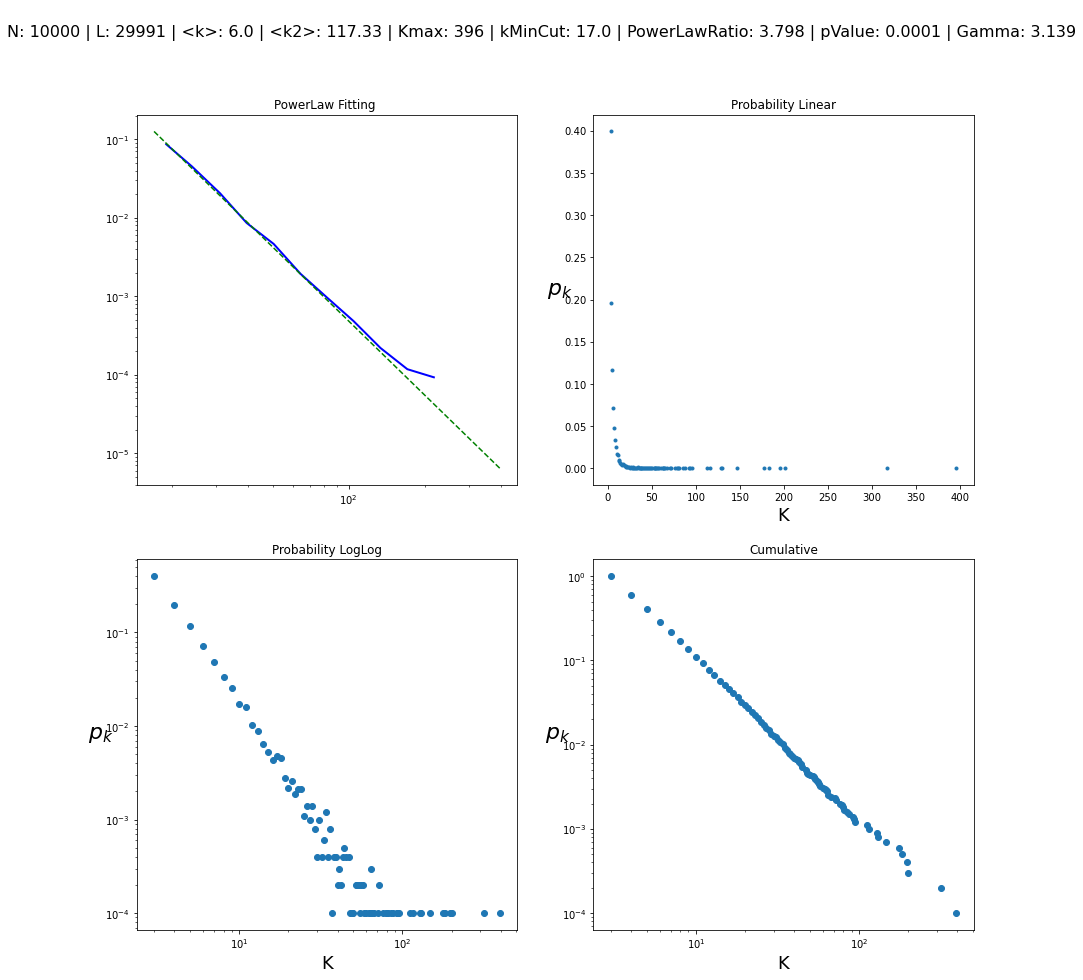

In [18]:
scaleFreePlot(scaleFree)

## Erdos and Renyi

In [13]:
random = nx.erdos_renyi_graph(10000,0.0006)
random.name="erdos_renyi_graph(10000,0.0006)"
print(nx.info(random))
degree=sorted(dict(random.degree()).values(),reverse=True)
print("10 biggest hubs degress:",degree[:10])

Name: erdos_renyi_graph(10000,0.0006)
Type: Graph
Number of nodes: 10000
Number of edges: 29793
Average degree:   5.9586
10 biggest hubs degress: [21, 16, 16, 16, 16, 15, 15, 15, 15, 15]


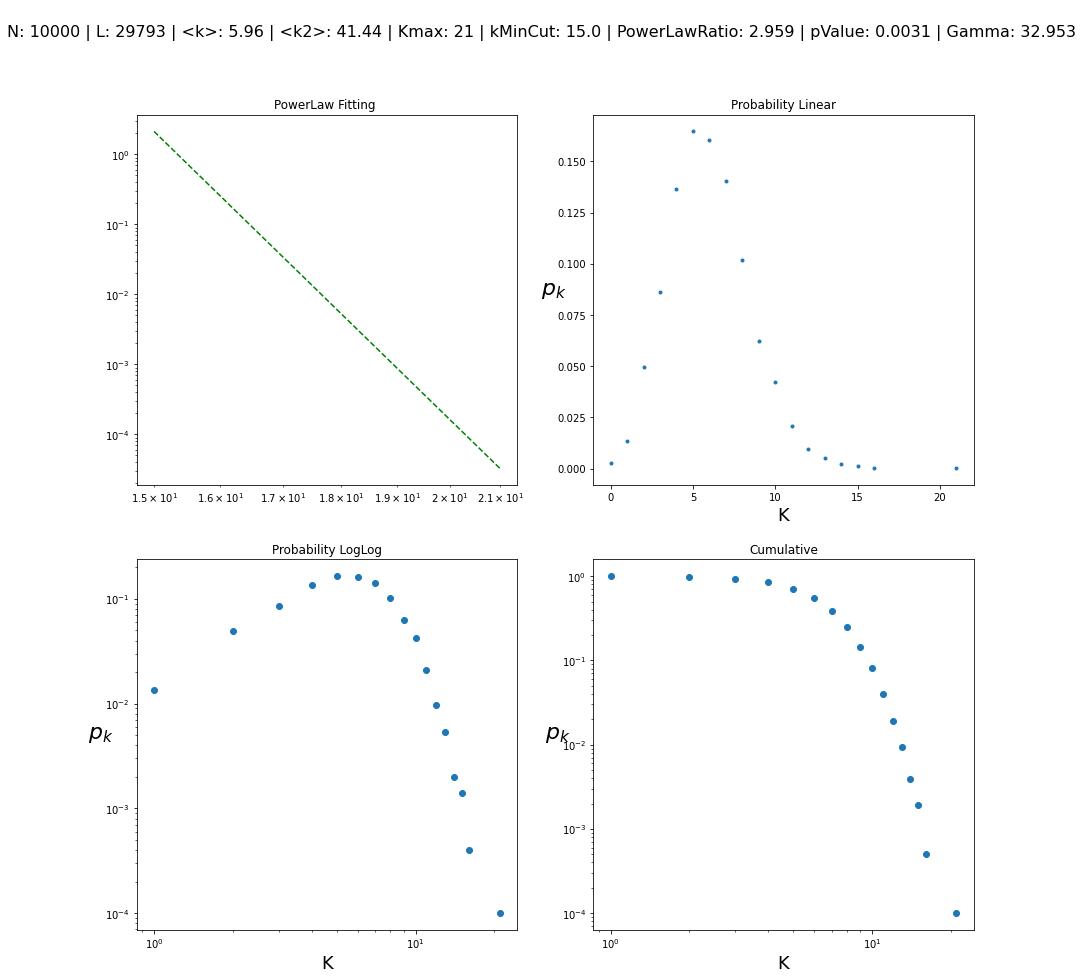

In [14]:
scaleFreePlot(random)

## Dorogovtsev, Goltsev and Mendes

In [7]:
dorogovtsev = nx.dorogovtsev_goltsev_mendes_graph(13)
dorogovtsev.name = "dorogovtsev(13)"
print(nx.info(dorogovtsev))
degree=sorted(dict(dorogovtsev.degree()).values(),reverse=True)
print("10 biggest hubs degress:",degree[:10])

Name: dorogovtsev(13)
Type: Graph
Number of nodes: 797163
Number of edges: 1594323
Average degree:   4.0000
10 biggest hubs degress: [8192, 8192, 8192, 4096, 4096, 4096, 2048, 2048, 2048, 2048]


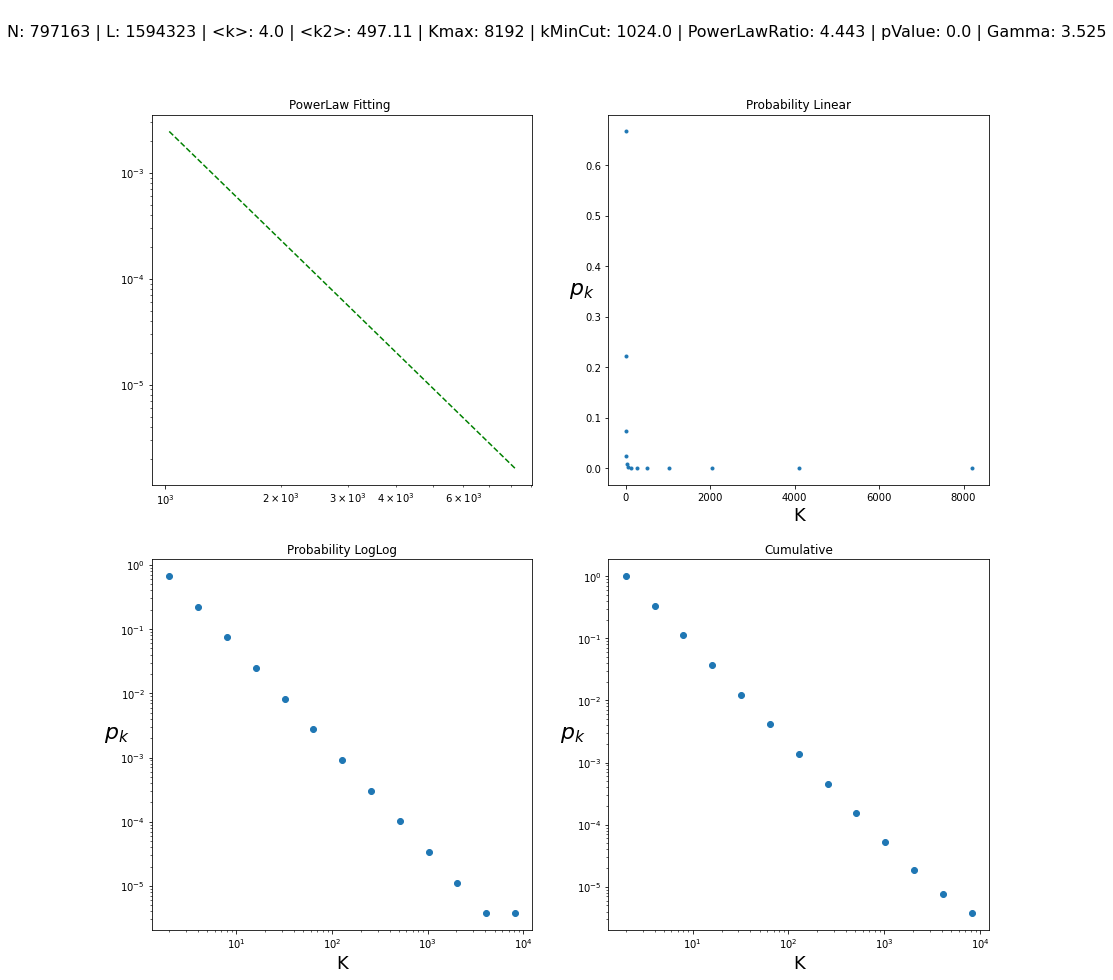

In [8]:
scaleFreePlot(dorogovtsev)

 # Degree Distribution Comparison
 ###### The PowerLaw package has a method (distribution_compare) that compares the degree distribution with other two distributions and gives a Ratio and a p-Value. 
"it is generally more sound and useful to compare the fits of many candidate distributions, and identify which one fits the best. Figure 1C visualizes the differences in fit between power law and exponential distribution. The goodness of these distribution fits can be compared with distribution_compare." 
###### Here we encapsulate this method in a function to show the target distribution against a power-law distribution and all other available distributions.
<b>PS: the warnings messages are from the package, as can be seen in their code:</b> https://github.com/jeffalstott/powerlaw/blob/master/powerlaw.py 

In [9]:
distributionComparison(scaleFree)

Comparasion with others distributions. The values area the Ration and pValue

power_law | exponential:           6.983230231371352 2.8846908749731005e-12


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


power_law | lognormal              -2.342189908683226 0.01917095731293337
power_law | truncated_power_law:   0.007033151788076288 0.9982626665499318
power_law | stretched_exponential: 3.991966147943391 6.552772863499468e-05
power_law | lognormal_positive:    4.86156125919524 1.1646352700016493e-06


In [10]:
distributionComparison(random)

Comparasion with others distributions. The values area the Ration and pValue

power_law | exponential:           3.886230583957437 0.00010181280413250743
power_law | lognormal              -2.894314634157593 0.003799871937220125
power_law | truncated_power_law:   0.00014658630953388074 0.9999545825607403
power_law | stretched_exponential: 3.777758377476198 0.00015824629532973887
power_law | lognormal_positive:    3.8337725825915756 0.00012619281784183965


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


In [11]:
distributionComparison(dorogovtsev)

Comparasion with others distributions. The values area the Ration and pValue

power_law | exponential:           4.442752025155327 8.881550605074848e-06
power_law | lognormal              -1.946595864162717 0.0515832048438011
power_law | truncated_power_law:   0.00011852838729133671 0.9998914100058943
power_law | stretched_exponential: 3.012085528461665 0.002594594829840834
power_law | lognormal_positive:    3.35836299431092 0.0007840557754357605


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
